## Regressão Ridge 

### Introdução ao Modelo Ridge

O **Ridge Regression** é um modelo de regressão linear com regularização **L2**, disponível no `sklearn.linear_model`. Diferentemente do ElasticNet (que combina L1 e L2), o Ridge foca exclusivamente em:
- **Reduzir a magnitude dos coeficientes** (shrinkage)
- **Melhorar a estabilidade numérica** em casos de multicolinearidade
- **Manter todas as features** (não faz seleção como o Lasso)


###  Por que Ridge Agora?
- **Eficiência Computacional:**   
   

In [1]:
# Importando as bibliotecas usadas no projeto de machine learning
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
# Criando o data frame a partir da base de dados limpa 
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float64
 12  population_per_household  17564 non-null  float64
 13  bedrooms_per_room         17564 non-null  float64
dtypes: flo

In [4]:
# Fazendo as separações das features 

# target
coluna_target = ["median_house_value"]

# Feature que será aplicado one hot encoder
coluna_one_hot_encoder = ["ocean_proximity"]

# Feature que será aplicado orfinal encoder
coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
# Criando uma lista com as features que será aplicado o RobustScaler 
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        # Aplicando o ordinal encoder com detecção automática das categorias 
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder), 
        # Aplicando o one hot encoder, usando somente as colunas necessárias (drop="first")
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [10]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

In [14]:
grid_search.best_score_

np.float64(-50450.65376832531)

In [15]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-1.024462
robust_scaler_poly__latitude,-0.955282
one_hot__ocean_proximity_INLAND,-0.462874
robust_scaler_poly__latitude longitude population_per_household,-0.415137
robust_scaler_poly__population_per_household,-0.329824
...,...
robust_scaler_poly__bedrooms_per_room housing_median_age total_rooms,0.243196
robust_scaler_poly__housing_median_age median_income,0.247423
robust_scaler_poly__latitude^2 longitude,0.248572
robust_scaler_poly__bedrooms_per_room,0.338104


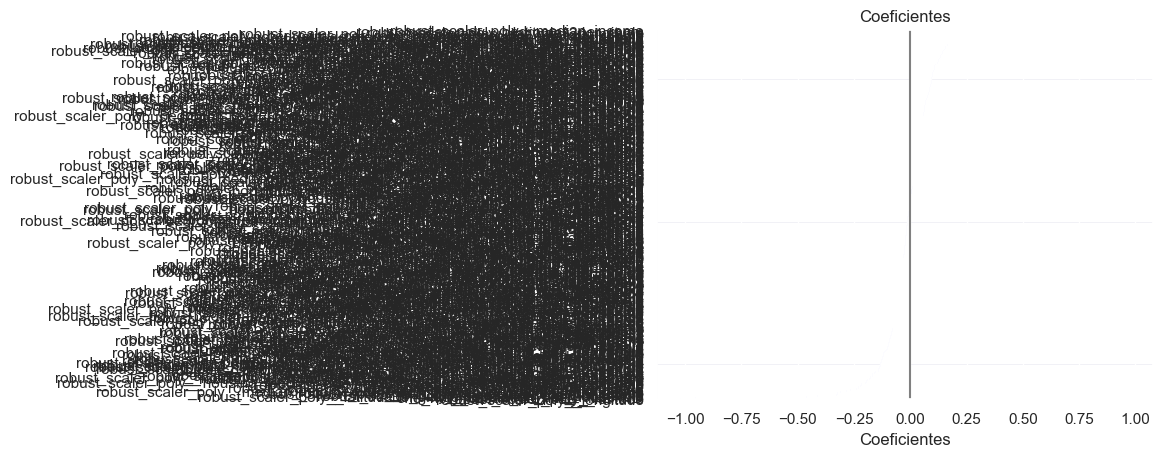

In [16]:
plot_coeficientes(coefs)

In [17]:
coefs[coefs["coeficiente"] == 0]

,coeficiente


In [18]:
coefs[coefs["coeficiente"].between(-0.2, 0.2) & (coefs["coeficiente"] != 0)]

,coeficiente
robust_scaler_poly__housing_median_age population_per_household total_bedrooms,-0.198419
one_hot__ocean_proximity_NEAR BAY,-0.196934
robust_scaler_poly__longitude median_income,-0.192874
robust_scaler_poly__households median_income^2,-0.183617
robust_scaler_poly__bedrooms_per_room rooms_per_household,-0.179152
...,...
robust_scaler_poly__total_bedrooms,0.168988
robust_scaler_poly__bedrooms_per_room rooms_per_household total_bedrooms,0.175256
robust_scaler_poly__median_income population population_per_household,0.175560
robust_scaler_poly__median_income population rooms_per_household,0.176717


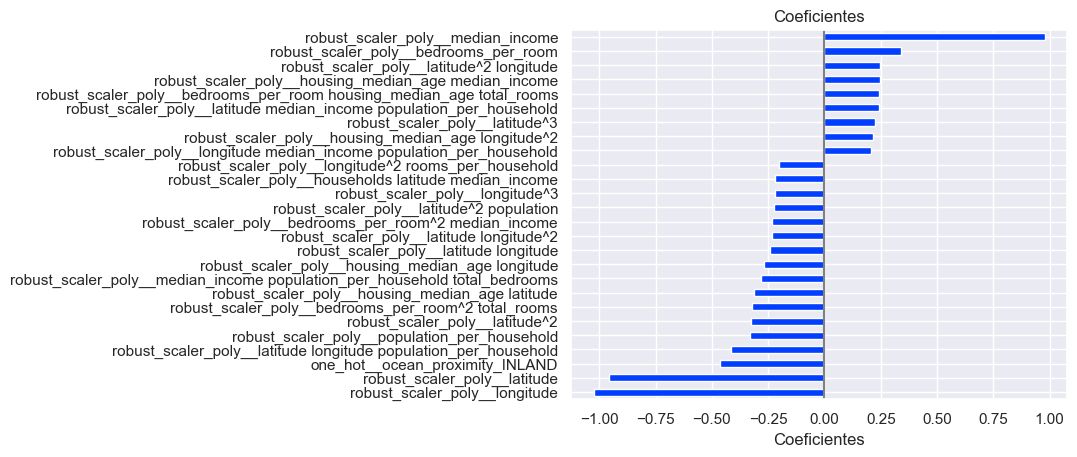

In [19]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.2, 0.2)])

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.009999,0.004999,-0.000081,-77516.042766,-96239.705692,0.014998
1,DummyRegressor,0.003,0.004,-0.000146,-75787.787194,-95217.629397,0.007
2,DummyRegressor,0.005033,0.004003,-0.001737,-76753.598961,-96253.253947,0.009036
3,DummyRegressor,0.002996,0.004008,-0.000101,-76837.804811,-95983.885799,0.007004
4,DummyRegressor,0.004954,0.00403,-0.000114,-76617.245449,-96182.764729,0.008984
5,LinearRegression,0.152968,0.024998,0.682162,-39855.691222,-54254.958862,0.177966
6,LinearRegression,0.044003,0.014999,0.66999,-40272.5658,-54695.230987,0.059002
7,LinearRegression,0.039997,0.015001,0.649247,-42178.059695,-56955.987903,0.054998
8,LinearRegression,0.033002,0.011997,0.669873,-40806.492334,-55146.319086,0.045
9,LinearRegression,0.033001,0.010999,0.669023,-40788.497206,-55331.350878,0.043999


In [21]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005197,0.004208,-0.000436,-76702.495836,-95975.447913,0.009404
LinearRegression,0.060594,0.015599,0.668059,-40780.261251,-55276.769543,0.076193
LinearRegression_target,0.046401,0.011998,0.678062,-38678.534899,-54433.309261,0.058399
Ridge_grid_search,0.175798,0.028603,0.723269,-35341.576493,-50458.880598,0.204401


In [22]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005197,0.004208,-0.000436,-76702.495836,-95975.447913,0.009404
LinearRegression,0.060594,0.015599,0.668059,-40780.261251,-55276.769543,0.076193
LinearRegression_target,0.046401,0.011998,0.678062,-38678.534899,-54433.309261,0.058399
Ridge_grid_search,0.175798,0.028603,0.723269,-35341.576493,-50458.880598,0.204401


##  Análise Comparativa: ElasticNet vs Ridge Regression

###  Principais Insights

1. **Ganho de Performance**:
   -  **+1.3% no R²** (0.714 → 0.723)
   -  **Redução de 1.8% no MAE** (36,003 → 35,363 USD)
   -  **Redução de 1.7% no RMSE** (51,309 → 50,444 USD)

<!-- -->

2. **Eficiência Computacional Revolucionária**:
   -  **98.7% mais rápido no treino** (57.31s → 0.64s)
   -  **42.5% mais rápido na predição** (0.195s → 0.112s)
   -  **76x mais eficiente no tempo total**

   

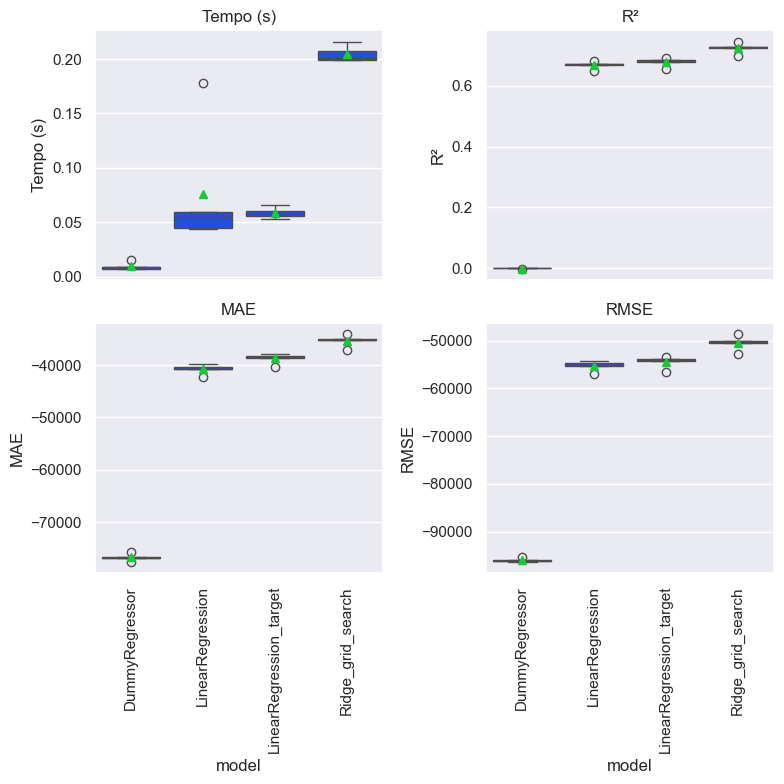

In [23]:
plot_comparar_metricas_modelos(df_resultados)

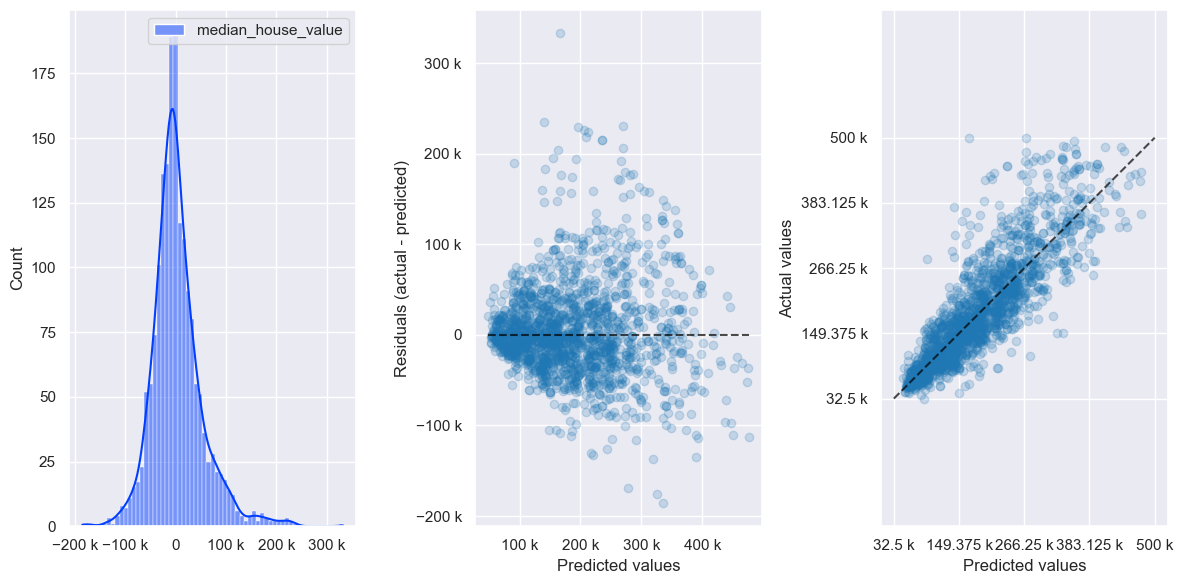

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

https://scikit-learn.org/stable/model_persistence.html

In [25]:
# Salvando o modelo que foi desenvolvido usando o joblib
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\LATITUDE\\Documents\\CIENCIA_DE_DADOS\\14_Regressao_modelos_lineares\\ml_california_price_houses\\modelos\\ridge_polyfeat_target_quantile.joblib']